# QAOA for the Max-Cut using Fire Opal

The Max-Cut problem is a canonical NP-hard problem in combinatorial optimization. Formally, given a weighted, undirected graph $G=(V,E,w)$, the task is to partition the vertex set into two disjoint groups such that the number (or weight) of edges crossing the partition is maximized. Given a weighted, undirected graph $G=(V,E,w)$, Max-Cut asks for a bipartition $V=A\cup B$ that maximizes the total weight of edges that cross the cut:

$$
\max_{A,B}\ \sum_{(i,j)\in E} w_{ij}\,[\![i\in A,\ j\in B]\!].
$$

With spin variables $s_i\in\{-1,+1\}$ (two colors), the objective can be written

$$
\max_{s\in\{\pm1\}^{|V|}} \sum_{(i,j)\in E} \frac{w_{ij}}{2}\bigl(1 - s_i s_j\bigr),
$$

which leads directly to the standard Ising form used in quantum algorithms:

$$
H_{\text{cut}} \;=\; \sum_{(i,j)\in E} \frac{w_{ij}}{2}\left(I - Z_i Z_j\right).
$$

Minimizing $\langle H_{\text{cut}}\rangle$ is equivalent to maximizing the cut.

## 1. Problem Definition

In [ ]:
import jijmodeling as jm
import matplotlib.pyplot as plt
import numpy as np
from functools import reduce
import networkx as nx

import qamomile.core as qm
import qamomile.qiskit as qm_qk

from scipy.optimize import minimize
from qiskit import transpile
from qiskit_ibm_runtime import SamplerV2
from qiskit_aer import AerSimulator

import fireopal as fo
from qiskit import qasm3
from pyscipopt import Model
import qctrlvisualizer as qv

if not hasattr(np, "alltrue"):
    np.alltrue = np.all

### 1.1 Create the graph

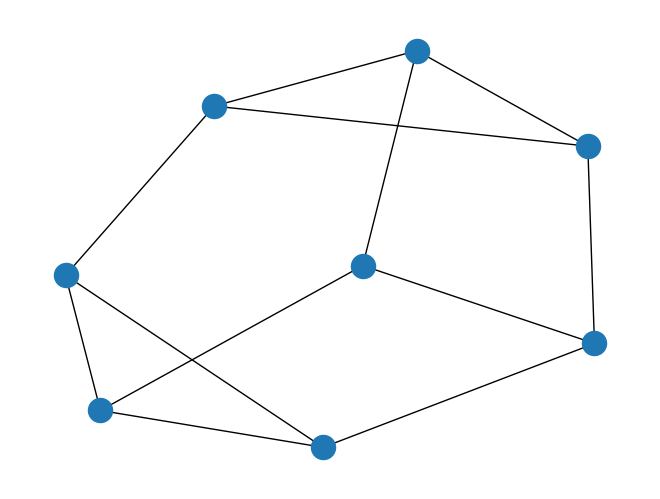

In [ ]:
graph = nx.random_regular_graph(d=3, n=8, seed=42)
nx.draw(graph, nx.kamada_kawai_layout(graph))

### 1.2 Construct the Mathematical Model

As mentioned before, the Max-Cut problem can be formulated with the following equation:

$$
  \max \quad \frac{1}{2} \sum_{(i,j) \in E} (1 - s_i s_j)  
$$

Note that this equation is expressed using Ising variables $ s \in \{ +1, -1 \} $. In this case, we want to formulate it using the binary variables $ x \in \{ 0, 1 \} $ from JijModeling. Therefore, we perform the conversion between Ising variables and binary variables using the following equations:

$$
    x_i = \frac{1 + s_i}{2} \quad \Rightarrow \quad s_i = 2x_i - 1
$$


In [ ]:
def Maxcut_problem() -> jm.Problem:
    V = jm.Placeholder("V")
    E = jm.Placeholder("E", ndim=2)
    x = jm.BinaryVar("x", shape=(V,))
    e = jm.Element("e", belong_to=E)
    i = jm.Element("i", belong_to=V)
    j = jm.Element("j", belong_to=V)

    problem = jm.Problem("Maxcut", sense=jm.ProblemSense.MAXIMIZE)
    si = 2 * x[e[0]] - 1
    sj = 2 * x[e[1]] - 1
    si.set_latex("s_{e[0]}")
    sj.set_latex("s_{e[1]}")
    obj = 1 / 2 * jm.sum(e, (1 - si * sj))
    problem += obj
    return problem

problem = Maxcut_problem()
problem

### 1.3 Prepare Instance Data

We now convert the graph information into the instance data that will be passed to the modeling and solver code. The instance consists of the number of vertices $V$ and an edge list $E$.

In [4]:
V = graph.number_of_nodes()
E = list(graph.edges())
data = {"V": V, "E": E}

### 1.4 Solve the Problem Classically

We solve Max-Cut to optimality using a linearized binary formulation implemented with [PySCIPOpt](https://pyscipopt.readthedocs.io/en/latest/). The node variables $x_i\in{0,1}$ encode the two partitions, the edge variables $e_{ij}\in{0,1}$ indicate whether an edge crosses the cut, and the linear constraints force each edge variable $e_{ij}$ to be $0$ when nodes $i$ and $j$ are in the same partition and allow $e_{ij}=1$ only when the nodes are in different partitions. The model maximizes the total edge weight crossing the cut and returns the cut value that serve as a classical baseline for the subsequent QAOA experiments.


In [ ]:
def solve_maxcut_classically(graph):
    """
    Solve the Max-Cut problem classically using linear programming.
    """
    model = Model("MaxCut")
    # Add binary variables for edges
    e = {(u, v): model.addVar(vtype="B", name=f"e({u, v})") for u, v in graph.edges()}
    # Add binary variables for nodes
    x = {u: model.addVar(vtype="B", name=f"x({u})") for u in graph.nodes()}

    # Define the objective function to maximize the cut value
    objective = sum(
        data.get("weight", 1) * e[(u, v)] for u, v, data in graph.edges(data=True)
    )
    model.setObjective(objective, "maximize")

    # Add constraints to ensure valid cuts
    for u, v in graph.edges():
        model.addCons(e[(u, v)] <= x[u] + x[v])
        model.addCons(e[(u, v)] <= 2 - (x[u] + x[v]))

    model.hideOutput(True)
    model.optimize()

    # Ensure the solution is optimal
    assert model.getStatus() == "optimal"

    # Return the solution indicating which partition each node belongs to
    return {u: model.getVal(x[u]) for u in graph.nodes()}

def cut_value(graph, cut):
    """
    Calculate the cut value of a given partition.
    """
    value = 0
    # Calculate the total weight of the cut edges
    for i, j, data in graph.edges(data=True):
        value += data.get("weight", 1) * np.round(cut[i] - cut[j]) ** 2
    return value

In [ ]:
solution = solve_maxcut_classically(graph)
optimal_cut_value = cut_value(graph, solution)
print(f"Classically derived cut value: {optimal_cut_value}")

Classically derived cut value: 10.0


## 2. QAOA Setup

### 2.1 Create a Compiled Instance
We perform compilation using `JijModeling.Interpreter` by providing the formulation and the instance data prepared earlier. This process yields an intermediate representation of the problem with the instance data substituted.

In [5]:
interpreter = jm.Interpreter(data)
compiled_model = interpreter.eval_problem(problem)

### 2.2 Convert Compiled Instance to QAOA Circuit and Hamiltonian
We generate the QAOA circuit and Hamiltonian from the compiled Instance. The converter used to generate these is `qm.qaoa.QAOAConverter`.

By creating an instance of this class and using `ising_encode`, you can internally generate the Ising Hamiltonian from the compiled Instance. Parameters that arise during the conversion to QUBO can also be set here. If not set, default values are used.

Once the Ising Hamiltonian is generated, you can generate the QAOA quantum circuit and the Hamiltonian respectively. These can be executed using the `get_qaoa_ansatz` and `get_cost_hamiltonian` methods. The number of QAOA layers, $p$, is fixed to be $9$ here.  

In [6]:
qaoa_converter = qm.qaoa.QAOAConverter(compiled_model)
qaoa_converter.ising_encode()
qaoa_hamiltonian = qaoa_converter.get_cost_hamiltonian()
p = 9
qaoa_circuit = qaoa_converter.get_qaoa_ansatz(p=p)

### 2.3 Visualization of QAOA Circuit
Qamomile provides a method to visualize the quantum circuit. You can use the plot_quantum_circuit function to visualize the QAOA quantum circuit.

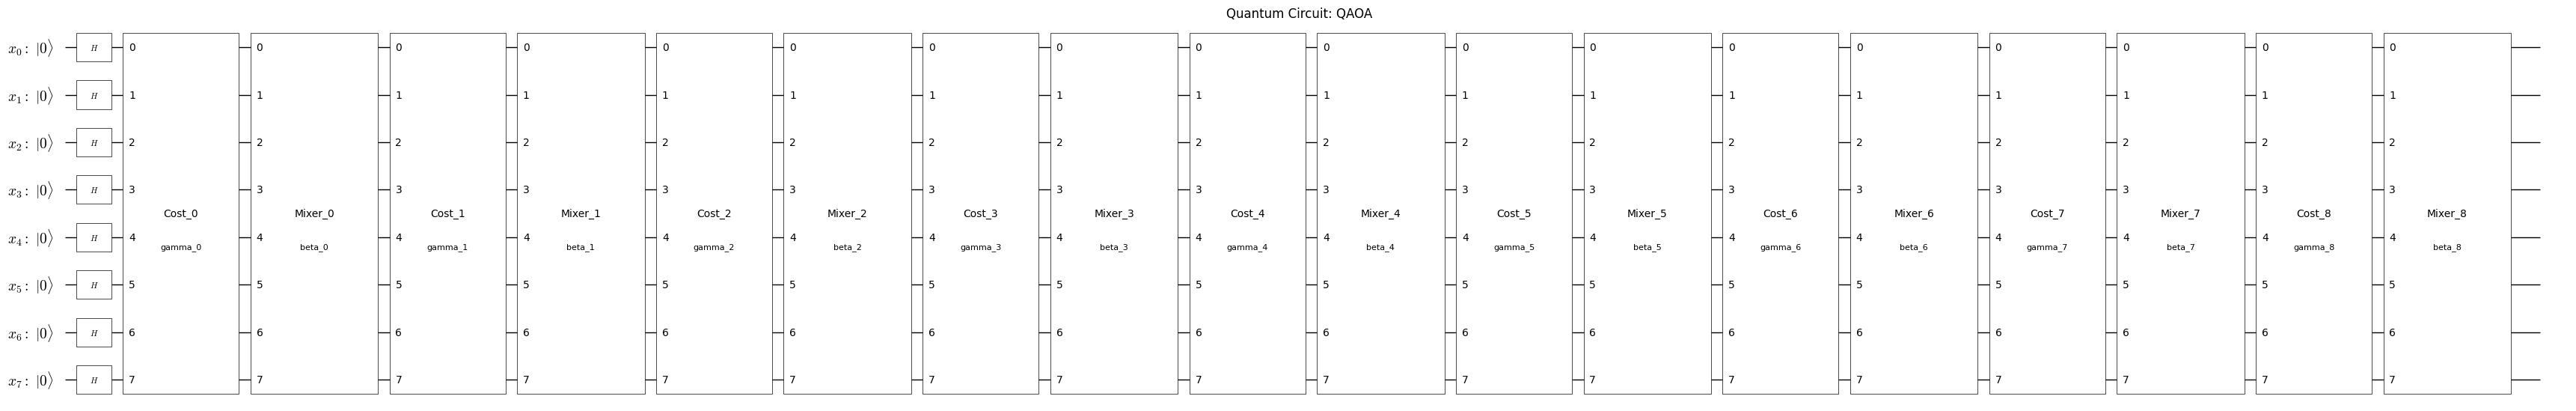

In [7]:
from qamomile.core.circuit.drawer import plot_quantum_circuit
plot_quantum_circuit(qaoa_circuit)

### 2.4 Convert the Obtained QAOA Circuit and Hamiltonian for Qiskit
We generate the Qiskit’s QAOA circuit and Hamiltonian using the `qamomile.qiskit.QiskitTranspiler` converters. By utilizing the two methods,`QiskitTranspiler.transpile_circuit` and `QiskitTranspiler.transpile_hamiltonian`, we can transform the QAOA circuit and Hamiltonian into a format compatible with Qiskit. This allows us to leverage Qiskit’s quantum computing framework to execute and analyze.

In [8]:
qk_transpiler = qm_qk.QiskitTranspiler()
# Transpile the QAOA circuit to Qiskit
qk_circuit = qk_transpiler.transpile_circuit(qaoa_circuit)
qk_circuit.measure_all()
# Transpile the QAOA Hamitltonian to Qiskit
qk_hamiltonian = qk_transpiler.transpile_hamiltonian(qaoa_hamiltonian)
qk_hamiltonian

SparsePauliOp(['IIIIIIZZ', 'IIIIIZIZ', 'IIZIIIIZ', 'IIIZIIZI', 'ZIIIIIZI', 'IIIIZZII', 'IIZIIZII', 'IZIIZIII', 'ZIIIZIII', 'IIZZIIII', 'IZIZIIII', 'ZZIIIIII', 'IIIIIIII'],
              coeffs=[ 0.5+0.j,  0.5+0.j,  0.5+0.j,  0.5+0.j,  0.5+0.j,  0.5+0.j,  0.5+0.j,
  0.5+0.j,  0.5+0.j,  0.5+0.j,  0.5+0.j,  0.5+0.j, -6. +0.j])

## 3. Circuit Optimization

First, we convert the measurement outcomes into a probability list over the computational basis states and use them to evaluate the expectation value $\langle H \rangle$ for a Hamiltonian defined in Pauli-Z/I form.  

In [9]:
def convert_probabilities_to_list(probabilities, nqubits,shots):
    """
    Transforms a dictionary of measured probabilities to a list of
    probabilities in the computational basis.
    """
    probs = []
    for key in range(2**nqubits):
        binary_key = format(key, "b").zfill(nqubits)
        probs.append(probabilities.get(binary_key, 0)/shots)
    return probs

def calculate_expectation(measured_probs, hamiltonian=qk_hamiltonian.to_list()):
    """
    Compute expectation value ⟨H⟩ 
    """
    pauli_lengths = {len(p) for p, _ in hamiltonian}
    n = pauli_lengths.pop()

    probs = np.asarray(measured_probs, dtype=float).ravel()
    total = probs.sum()
    probs = probs / total

    # eigenvalues for a Z/I-only Pauli string via Kronecker products
    def eigenvalues_from_pauli(pstr):
        vec_map = {"I": np.array([1.0, 1.0]), "Z": np.array([1.0, -1.0])}
        return reduce(np.kron, (vec_map[c] for c in pstr))

    eigen_cache = {}
    expectation = 0.0
    for pstr, coeff in hamiltonian:
        c = float(np.real(coeff))
        if pstr == "I" * n:
            expectation += c * 1.0
            continue
        if pstr not in eigen_cache:
            eigen_cache[pstr] = eigenvalues_from_pauli(pstr)
        ev = eigen_cache[pstr]
        expectation += c * float(np.dot(ev, probs))

    return expectation


Then, we define the QAOA cost function using measured expectation values and optimizes it through a classical optimizer. A parameterized quantum circuit is transpiled and executed on the Qiskit Simulator. The measurement outcomes are converted into probability distributions, which are then used to evaluate the expectation value $\langle H \rangle$. A COBYLA optimizer minimizes this cost function, while the optimization trajectory is stored in `cost_history` for later analysis.  

In [10]:
from qiskit_ibm_runtime import QiskitRuntimeService
from qiskit_ibm_runtime import SamplerV2 as Sampler
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager

backend = AerSimulator(method="matrix_product_state")

service = QiskitRuntimeService()
num_shots = 10000
cost_history = []

sampler = Sampler(backend)

def estimate_cost(parameters):
        parameters_dict = {param.name: val for param, val in zip(qk_circuit.parameters, parameters)}
        qc = qk_circuit.assign_parameters(parameters_dict)
        
        pm = generate_preset_pass_manager(backend=backend, optimization_level=3)
        isa_circuit = pm.run(qc)
        job = sampler.run([isa_circuit], shots=num_shots)
        counts = job.result()[0].data.meas.get_counts()
        measured_probs = convert_probabilities_to_list(counts, qc.num_qubits,num_shots)
        expectation_value = calculate_expectation(measured_probs)
        cost_history.append(expectation_value)
        return expectation_value

# Create initial parameters
initial_params = np.random.uniform(low=-np.pi, high=np.pi, size=2 * p)

# Run QAOA optimization
result = minimize(
    estimate_cost,
    initial_params,
    method="COBYLA",
    options={"maxiter": 1500, "tol":0.001},
)
print(result)

 message: Return from COBYLA because the trust region radius reaches its lower bound.
 success: True
  status: 0
     fun: -9.1994
       x: [ 1.953e+00  3.011e+00 ... -3.257e+00 -2.216e+00]
    nfev: 120
   maxcv: 0.0


In [11]:
result.x

array([ 1.95251476,  3.01070773,  0.33542063,  2.05406806,  2.15966726,
       -1.8168239 , -2.97508395, -1.47055884,  1.23108952, -1.52308521,
       -2.95101486, -0.26587223,  0.51892019, -2.72830304, -3.1250238 ,
       -1.97559733, -3.25651195, -2.21613665])

### 3.1 Cost Function Visualization

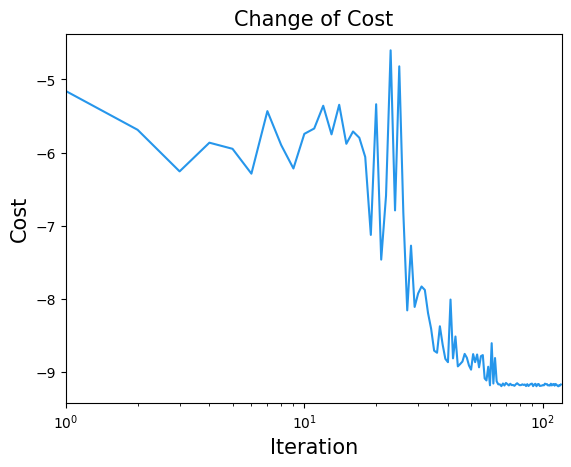

In [ ]:
plt.title("Change of Cost", fontsize=15)
plt.xlabel("Iteration", fontsize=15)
plt.ylabel("Cost", fontsize=15)
plt.xscale("log")
plt.xlim(1, result.nfev)
plt.plot(cost_history, label="Cost", color="#2696EB")
plt.show()

### 3.2 Execute optimized ansatz
Run the optimized parameterized QAOA ansatz on the Qiskit simulator to obtain measurement distributions, from which we compute $\langle H_{\rm cost}\rangle$ and the resulting Max-Cut value for comparison with the classical result.


In [13]:
# Run Optimized QAOA circuit
sampler = SamplerV2(backend)
qc = qk_circuit.assign_parameters(result.x)
transpiled_circuit = transpile(qc, backend)
job = sampler.run([transpiled_circuit], shots=10000)
job_result = job.result()[0]
qaoa_sim = job_result.data["meas"]

### 3.3 Evaluate the Results
From the job counts obtained earlier, we can transfer them to a sampleset by `qaoa_converter.decode`.
The sampleset can select only the feasible solutions and then we examine the distribution of the objective function values.

In [14]:
sampleset = qaoa_converter.decode(qk_transpiler, qaoa_sim)
plot_data = {}
energies_simulation = []
frequencies_simulation = []

# Create a dictionary to group energies and count their frequencies
from collections import defaultdict
energy_freq_simulation = defaultdict(int)

for sample_id in sampleset.sample_ids:
    sample = sampleset.get(sample_id)
    energy_freq_simulation[sample.objective] += 1
norm = max(energy_freq_simulation.values())
energies_simulation = list(energy_freq_simulation.keys())
frequencies_simulation = [item / norm for item in list(energy_freq_simulation.values())]

## 4. Execute optimized QAOA on Qiskit

Run the optimized QAOA ansatz on a Qiskit backend. The workflow below transpiles and executes the optimized circuit, decodes the returned samples into bitstrings and objective energies via `qaoa_converter.decode`, aggregates counts by energy, and normalizes frequencies.

### 4.1 Set up your environment

To run this section, you will need an [IBM Quantum account](https://quantum.cloud.ibm.com/). Set up your IBM account information to choose a backend.

In [ ]:
api_key = "YOUR_QCTRL_API_KEY"
fo.authenticate_qctrl_account(api_key=api_key)

# Set credentials.
token = "YOUR_IBM_CLOUD_API_KEY"
instance = "YOUR_IBM_CRN"

credentials = fo.credentials.make_credentials_for_ibm_cloud(
    token=token, instance=instance
)

service = QiskitRuntimeService.save_account(
    token=token, instance=instance, overwrite=True
)

Q-CTRL authentication successful!


In [ ]:
shot_count = 10000
service = QiskitRuntimeService()
backend = service.backend("ibm_marrakesh")
backend_name = backend.name

In [ ]:
# Run Optimized QAOA circuit
sampler = SamplerV2(backend)
qc = qk_circuit.assign_parameters(result.x)
transpiled_circuit = transpile(qc, backend)
job = sampler.run([transpiled_circuit], shots=10000)
job_result = job.result()[0]
qaoa_qiskit = job_result.data["meas"]

In [ ]:
sampleset = qaoa_converter.decode(qk_transpiler, qaoa_qiskit)
plot_data = {}
energies_qiskit = []
frequencies_qiskit = []

# Create a dictionary to group energies and count their frequencies
from collections import defaultdict
energy_freq_qiskit = defaultdict(int)

for sample_id in sampleset.sample_ids:
    sample = sampleset.get(sample_id)
    energy_freq_qiskit[sample.objective] += 1
norm = max(energy_freq_qiskit.values())
energies_qiskit = list(energy_freq_qiskit.keys())
frequencies_qiskit = [item / norm for item in list(energy_freq_qiskit.values())]

## 5. Execute optimized QAOA with Fire Opal

This section presents the outcomes obtained using Qamomile with Fire Opal optimization. The results demonstrate the improvements achieved, providing a direct comparison against the baseline execution without Fire Opal.  

### 5.1 Prepare the circuit and Hamiltonian for Fire Opal

In [18]:
# Obtain a list of PauliOperators from the Qiskit Hamiltonian
hamiltonian = qk_hamiltonian.to_list()
# Convert to OpenQASM3
qasm_circ = qasm3.dumps(qk_circuit.decompose())

### 5.2 QAOA Optimization
Since Fire Opal provides a built-in method to calculate expectation values directly from QASM circuits, we can define the QAOA objective function in a straightforward way by mapping parameters to the circuit and passing them to the `estimate_expectation` routine.  


Now, let's run the Optimized paremeter on qiskit using Fire Opal.

In [19]:
parameters_dict = {param.name: val for param, val in zip(qk_circuit.parameters, result.x)}
job = fo.execute(
    circuits=[qasm_circ],
    parameters=[parameters_dict],
    credentials=credentials,
    backend_name=backend_name,
    shot_count=shot_count,
)

In [20]:
def maxcut_obj(bitstring: str, graph: nx.Graph) -> float:
    """
    Given a bitstring, this function returns the number of edges
    shared between the two partitions of the graph.
    """
    obj = 0
    # Iterate through each edge in the graph
    for i, j, data in graph.edges(data=True):
        # Calculate the contribution of the edge to the Max-Cut objective
        # If the nodes are in different partitions, the term (int(bitstring[i]) - int(bitstring[j]))**2 will be 1
        # Otherwise, it will be 0
        obj -= data.get("weight", 1) * (int(bitstring[i]) - int(bitstring[j])) ** 2
    return obj

def get_cost_distribution(
    distribution: dict[str, int], graph: nx.Graph
) -> tuple[np.ndarray, np.ndarray]:
    """
    Given a bitstring count distribution and a graph, returns the
    costs and relative probabilities as numpy arrays.
    """
    # Total number of bitstrings (shots)
    norm = max(distribution.values())
    costs = []
    probabilities = []
    # Calculate the cost and probability for each bitstring
    for bitstring, count in distribution.items():
        # Reverse the bitstring to match graph node indices
        cost = -maxcut_obj(bitstring[::-1], graph)
        costs.append(cost)
        probabilities.append(count/norm)
    return np.array(costs), np.array(probabilities)


In [ ]:
results = job.result()["results"][0]
fire_opal_counts = {
    bitstring: int(probability * 10000)
    for bitstring, probability in results.items() 
    if int(probability * 10000) > 0
}
energies_fo, frequencies_fo = get_cost_distribution(fire_opal_counts, graph)

## 6. Frequency Distribution: With vs Without Fire Opal

The following plot compares the normalized frequency distribution of measurement outcomes at different energy levels when running circuits with and without Fire Opal optimization compared with the simulation baseline. Bars are grouped side by side for each energy value. This visualization highlights the relative differences in how noise mitigation affects sampling across energy states.

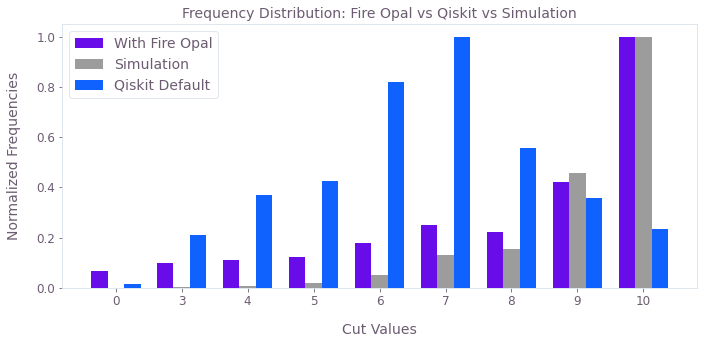

In [ ]:
def group_max(energies, freqs):
    """Return dict: energy -> max(freq) using exact float keys."""
    d = {}
    for e, f in zip(energies, freqs):
        e = float(e); f = float(f)
        if e in d:
            if f > d[e]:
                d[e] = f
        else:
            d[e] = f
    return d

res_fo = group_max(energies_fo, frequencies_fo)
res_qa = group_max(energies_simulation, frequencies_simulation)
res_qi = group_max(energies_qiskit, frequencies_qiskit)   

all_E = sorted(set(res_fo) | set(res_qa) | set(res_qi))

y_fo = [res_fo.get(e, 0.0) for e in all_E]
y_qa = [res_qa.get(e, 0.0) for e in all_E]
y_qi = [res_qi.get(e, 0.0) for e in all_E]                
bar_width = 0.25
x = np.arange(len(all_E))

fig, ax = plt.subplots(figsize=(10, 5))
ax.bar(x - bar_width,        y_fo, bar_width, label="With Fire Opal")
ax.bar(x,       y_qa, bar_width, label="Simulation", color="#9C9C9C")
ax.bar(x+ bar_width,                   y_qi, bar_width, label="Qiskit Default", color="#0f62fe")
ax.set_xlabel("Cut Values")
ax.set_ylabel("Normalized Frequencies")
ax.set_title("Frequency Distribution: Fire Opal vs Qiskit vs Simulation")

def fmt_energy(e):
    return str(int(e)) if float(e).is_integer() else f"{e:.6g}"

plt.style.use(qv.get_qctrl_style())
ax.set_xticks(x)
ax.set_xticklabels([fmt_energy(e) for e in all_E], rotation=0)
ax.legend()

overall_max = max(max(y_fo + y_qa + y_qi), 1.0)
ax.set_ylim(0, 1.05 * overall_max)

plt.tight_layout()
plt.show()